In [1]:
import pints
import numpy as np
import math
from scipy.constants import N_A
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
from numba import njit
import pandas as pd


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/homebrew/Cellar/python@3.10/3.10.15/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/Cellar/python@3.10/3.10.15/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/homebrew/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/lib/python3.10/s

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [387]:
#Constants

Target_cell_number = 1e4
E_T_ratio = 5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2


t_end = 60*60*5
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

kon = 2.5e5
qon = 6.5e3
koff = 1.5e-4
qoff = 4.7e-3
rtot = 5.3e4
D_t = 6.8e-15
D_f = 7.4e-14

In [388]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

@njit
def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =   - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [389]:
print(2*(D_t +D_f)/(synapse_area))  

0.0016159999999999996


In [390]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, chi, chi2):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot =A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = [A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0]
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    #k4 = 2*(D_t +D_f)/(synapse_area)   
    #k5 = (2*(D_t +D_f)/(synapse_area))/chi
    k4 = chi2
    k5 = chi
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF',  rtol = 1e-4, atol=1e-3, t_eval=t, args=[k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot])
    if z.success == False:
        print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return crosslinks

In [391]:
@njit
def fc_func(Emax, Efc50, fc, ftot):

    return (Emax*(fc/ftot))/(Efc50 + (fc/ftot))

def simulate_model(A0s, parameters):
    chi = parameters[0]
    chi = 10**chi
    chi2 = parameters[1]
    chi2 = 10**chi2
    Efc50 = parameters[2]
    Efc50 = 10**Efc50
    ftot = parameters[3]
    ftot = 10**ftot
    #Emax = parameters[4]
    Emax = 1

    solution = np.zeros_like(A0s)

    for i, Ainit in enumerate(A0s):
        solution[i] = calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, chi, chi2)
        
    
    solution = fc_func(Emax, Efc50, solution, ftot)
    return solution
    
class model(pints.ForwardModel):

    def n_outputs(self):
         return super().n_outputs()
    
    def n_parameters(self):
        return 4
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)

In [392]:
#extract data

#df = pd.read_csv('/Users/lukeheirene/ADCC-Project/__pycache__/Synapse Model Parameter Fitting/Mazor_data/anti_cd4_WT_cyto.csv')
df = pd.read_csv('/Users/lukeheirene/ADCC-Project/__pycache__/Synapse Model Parameter Fitting/Mazor_data/SK0V3_WT_5:1.csv')
A0s = df['concentration'].values
A0s = A0s*1e-9
values = df[' cytotoxicity RLU']
values = values/60

In [393]:
mod = model()
problem = pints.SingleOutputProblem(mod, A0s, values)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = [-3, -3, -1, 5, 0.5]
#print(parameters)
log_prior = pints.UniformLogPrior(
    [-12, -12, -3, 3, 0.01],
    [-1, -1, 0, 8, 5]
)
#log_prior_theta1 = pints.UniformLogPrior(lower_or_boundaries=-12, upper=-1)
#log_prior_theta2 = pints.UniformLogPrior(lower_or_boundaries=-12, upper=-1)
#log_prior_theta3 = pints.UniformLogPrior(lower_or_boundaries=-1, upper=6)
#log_prior_theta4 = pints.UniformLogPrior(lower_or_boundaries=3, upper=8)
#log_prior_sigma = pints.GaussianLogPrior(mean=0, sd=3)
#log_prior = pints.ComposedLogPrior(log_prior_theta1, log_prior_theta2, log_prior_theta3, log_prior_theta4, log_prior_sigma)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [394]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [395]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(5000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:01.0
1     8      0.5       0.5       0         0.5        0:01.4
2     12     0.333     0.667     0         0.667      0:01.7
3     16     0.5       0.75      0.25      0.5        0:02.0
20    84     0.571     0.429     0.333     0.667      0:07.5
40    164    0.561     0.293     0.317     0.683      0:14.0
60    244    0.475     0.246     0.279     0.656      0:20.7
80    324    0.432     0.259     0.296     0.556      0:27.1
100   404    0.366     0.248     0.257     0.495      0:32.8
120   484    0.331     0.256     0.264     0.438      0:38.5
140   564    0.291     0.248227  0.291     0.39       0:44.3
160   644    0.310559  0.255     0.286     0.354      0:50.7
180   724    0.293     0.271     0.304     0.354      0:57.6
Initial phase completed.
200   804    0.294     0.

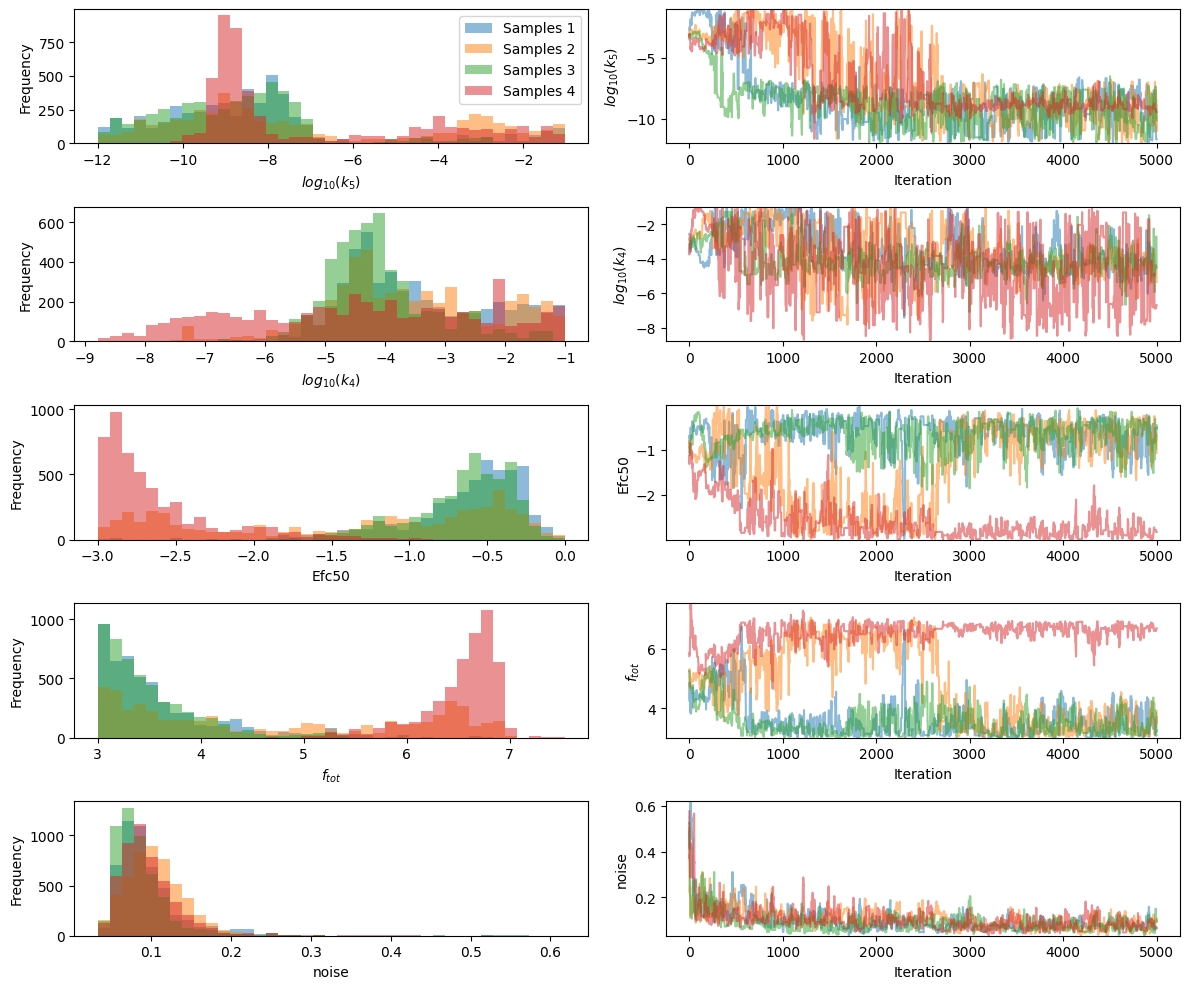

In [396]:
import pints.plot
pints.plot.trace(chains, parameter_names=[r'$log_{10}(k_5)$', r'$log_{10}(k_4)$',r'Efc50', r'$f_{tot}$','noise'])
plt.show()

In [397]:
chain = chains[0]
chain = chain[2000:]
chains1 = chains[:, 2000 :]

In [398]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=[r'log10(k5)', r'log10(k4)', r'Efc50', r'ftot','noise'])
print(results)


param      mean    std.    2.5%    25%     50%    75%    97.5%    rhat    ess     ess per sec.
---------  ------  ------  ------  ------  -----  -----  -------  ------  ------  --------------
log10(k5)  -9.05   1.54    -11.68  -10.00  -9.03  -8.35  -5.44    1.07    176.45  0.20
log10(k4)  -4.28   1.31    -7.41   -4.83   -4.31  -3.64  -1.46    1.08    328.71  0.38
Efc50      -1.30   1.01    -2.98   -2.61   -0.80  -0.47  -0.23    2.33    217.17  0.25
ftot       4.42    1.49    3.02    3.22    3.63   6.42   6.88     2.56    219.19  0.25
noise      0.08    0.02    0.05    0.07    0.08   0.10   0.14     1.06    217.11  0.25


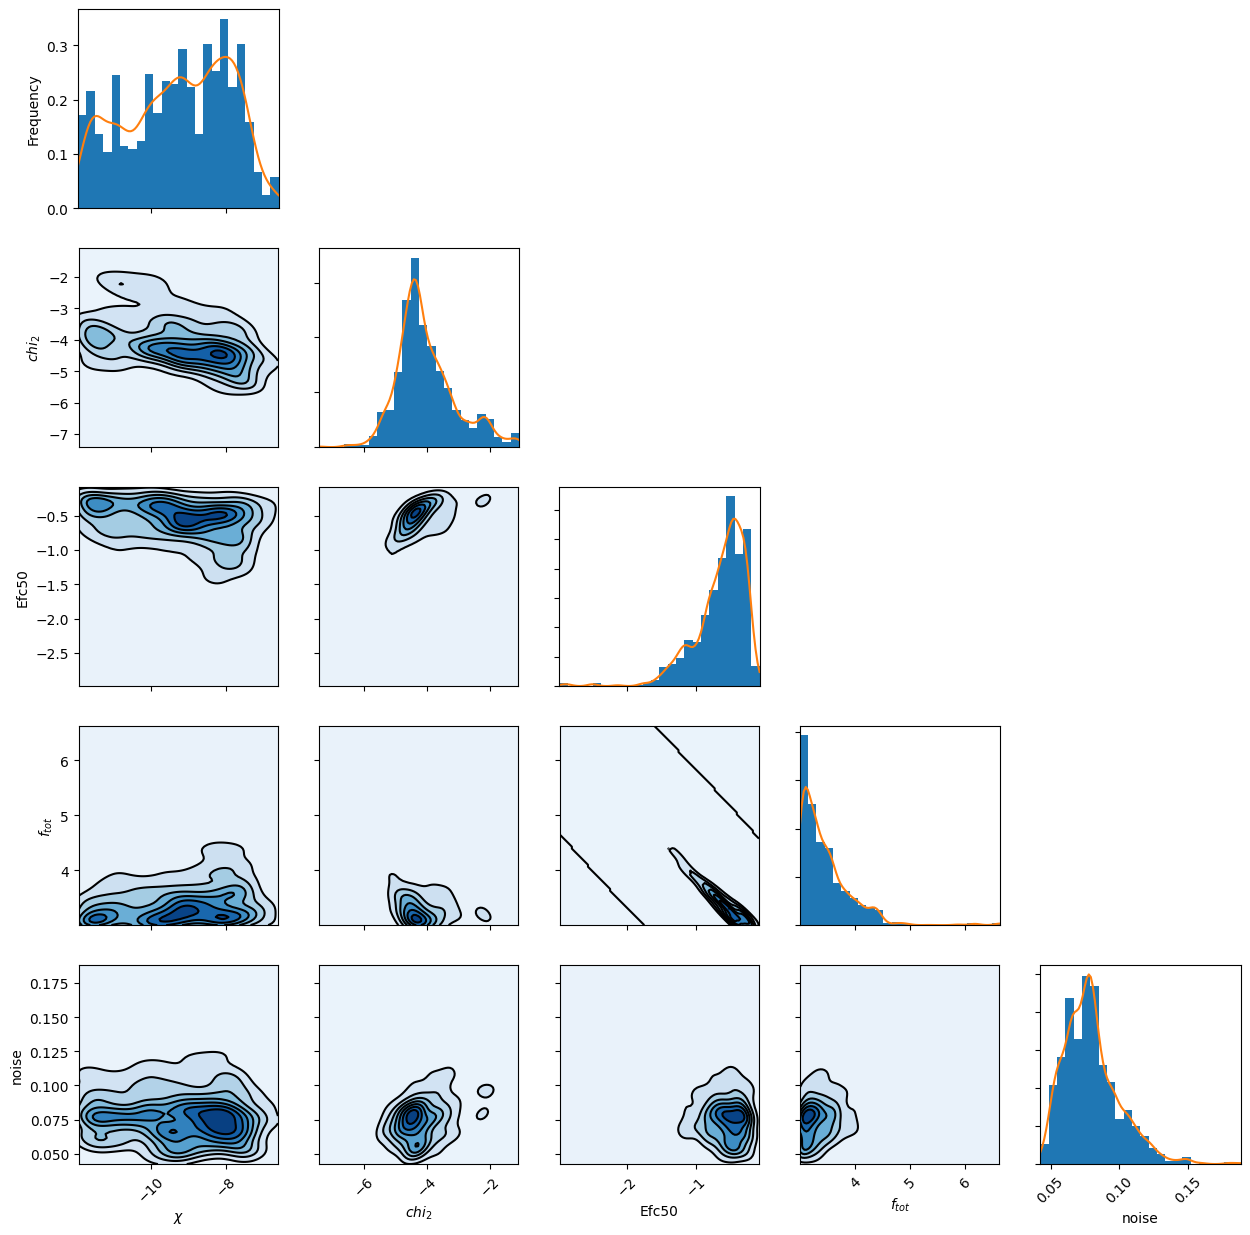

In [399]:
pints.plot.pairwise(chain, kde=True,  parameter_names=[r'$\chi$', r'$chi_2$', r'Efc50', r'$f_{tot}$', 'noise'])
plt.show()

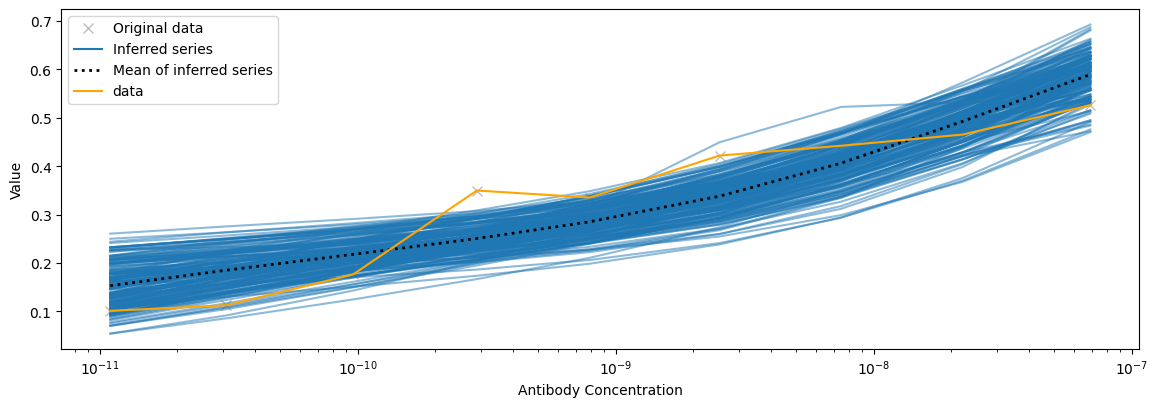

In [400]:
fig, axes = pints.plot.series(chains1[0], problem)

fig.set_size_inches(12,4.5)
plt.plot(A0s, values, c='orange', label='data')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()